#### Imports

In [29]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [ ]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

#### Connect to Hopsworks Feature Store

In [ ]:
with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 


#### Feature View Retrieval


In [32]:
feature_view = fs.get_feature_view(
    name='accidents_fv',
    version=1,
)

#### Download the model from Model Registry

In [ ]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="accident_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [ ]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

#### Get Weather Forecast Features with Feature View


In [ ]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

#### Making the predictions

In [ ]:
batch_data['predicted_accidents'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'day_of_week']])
batch_data.sort_values(by='date', inplace=True)

batch_data


In [ ]:
batch_data.info()

#### Saving the predictions (for monitoring) to a Feature Group

In [ ]:
batch_data['city'] = "Stockholm"
batch_data['country'] = "Sweden"
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

In [ ]:
batch_data.info()

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

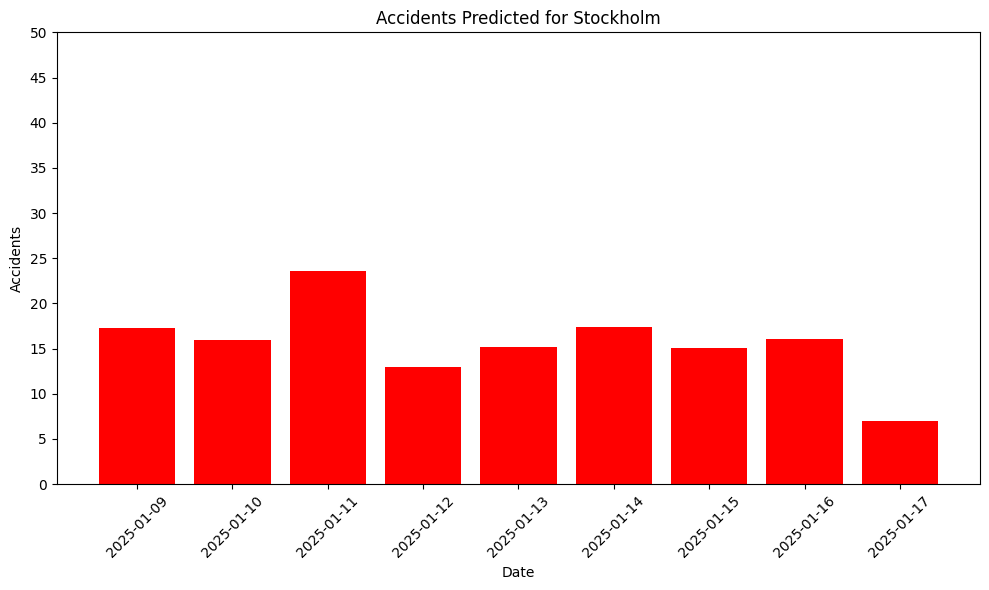

In [46]:
import os
from functions import util
file_path = "../data/forecast.png"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt = util.plot_accidents_forecast("Stockholm", batch_data, file_path=file_path)
plt.show()

In [41]:
import os
from functions import util
file_path = "../data/forecast_table.png"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt = util.plot_accidents_table("Stockholm", batch_data, file_path=file_path)
plt.show()

In [42]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='accidents_predictions',
    description='Accidents prediction monitoring',
    version=1,
    primary_key=['city','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})